# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [322]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [323]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [324]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(5, 2, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [325]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise)# Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [326]:
from sklearn.metrics import mean_squared_error

In [327]:
err = []
LRs = []

for N in N_grid:
    LR = lm.LinearRegression()
    rnd_ind = np.random.choice(np.arange(X.shape[0]), N)
    LR.fit(X[rnd_ind], y[rnd_ind])
    LRs.append(LR)
    y_pred = LR.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))

Код для построения графиков:

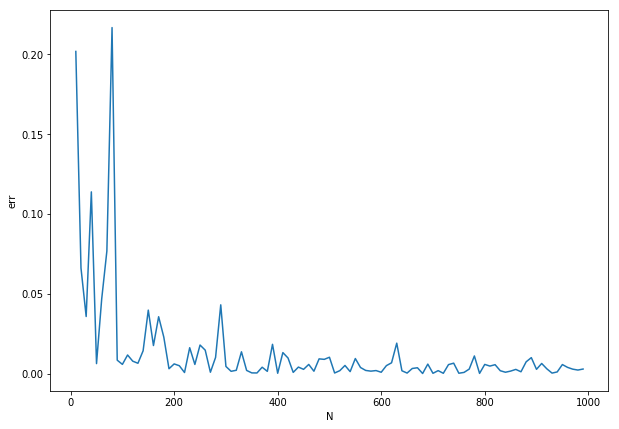

In [328]:
plt.figure(figsize=(10, 7))
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

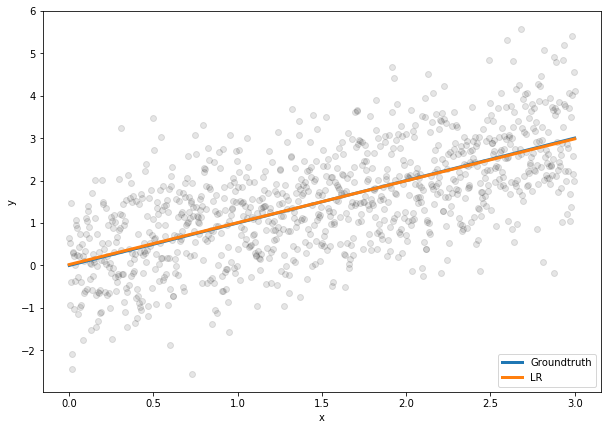

In [329]:
plt.figure(figsize=(10, 7))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [330]:
from sklearn.neighbors import KNeighborsRegressor

In [331]:
err = []
KNNs = []

for N in N_grid:
    knn = KNeighborsRegressor(n_neighbors=3)
    rnd_ind = np.random.choice(np.arange(X.shape[0]), N)
    knn.fit(X[rnd_ind],y[rnd_ind])
    KNNs.append(knn)
    y_pred = knn.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))
    

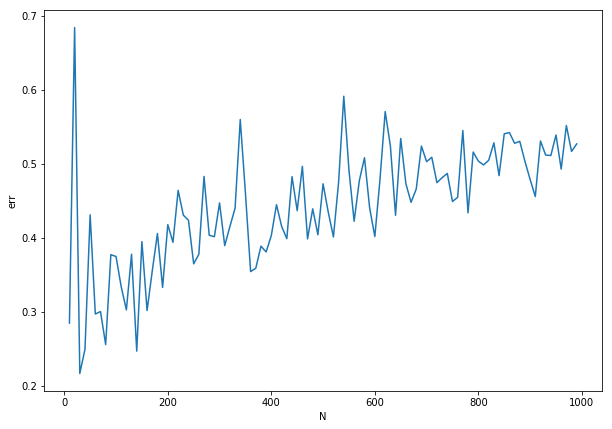

In [332]:
plt.figure(figsize=(10,7))
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')


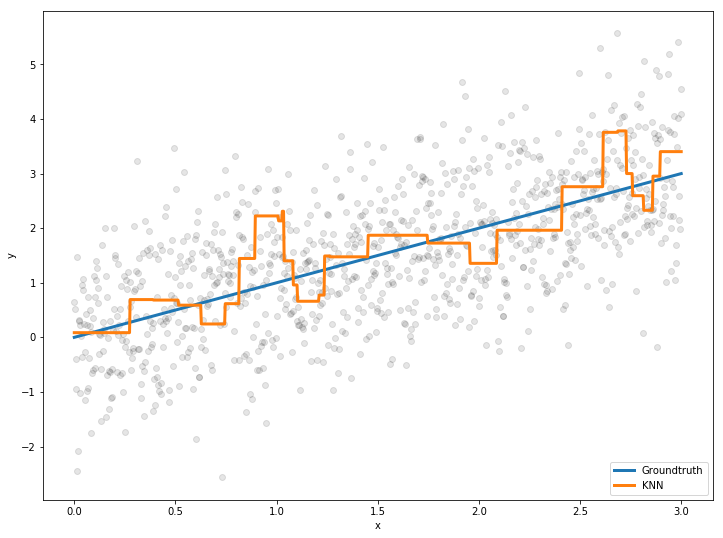

In [333]:
plt.figure(figsize=(12,9))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
print(KNNs[np.argmin(err)])
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [334]:
err = []
KNNs = []

for N in N_grid:
    knn = KNeighborsRegressor(n_neighbors=10)
    rnd_ind = np.random.choice(np.arange(X.shape[0]), N)
    knn.fit(X[rnd_ind],y[rnd_ind])
    KNNs.append(knn)
    y_pred = knn.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))

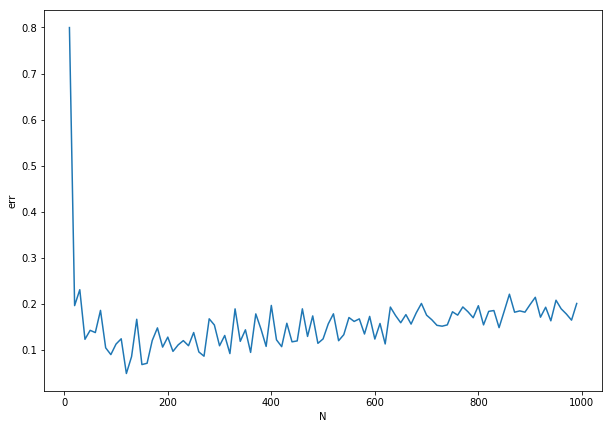

In [335]:
plt.figure(figsize=(10,7))
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')


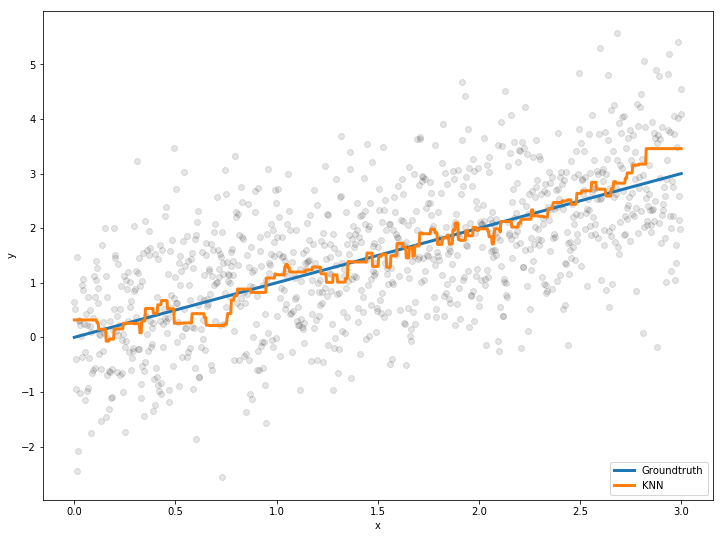

In [336]:
plt.figure(figsize=(12,9))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
print(KNNs[np.argmin(err)])
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Решил проверить еще для 25 соседей

In [337]:
err = []
KNNs = []

for N in N_grid:
    neib_num = 10;
    if N > 25: 
        neib_num = 25;
    knn = KNeighborsRegressor(n_neighbors=neib_num )
    rnd_ind = np.random.choice(np.arange(X.shape[0]), N)
    knn.fit(X[rnd_ind],y[rnd_ind])
    KNNs.append(knn)
    y_pred = knn.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))

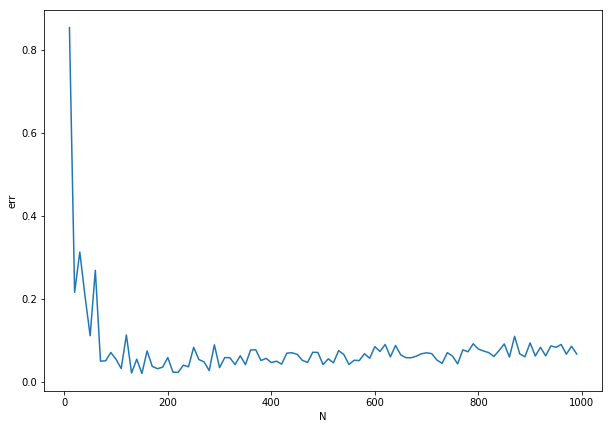

In [338]:
plt.figure(figsize=(10,7))
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=25, p=2,
          weights='uniform')


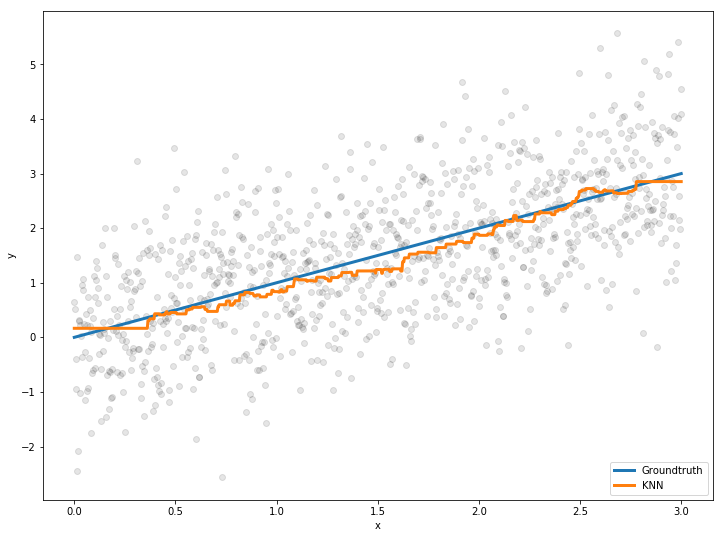

In [339]:
plt.figure(figsize=(12,9))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
print(KNNs[np.argmin(err)])
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

Регрессионная прямая перестает быть отличима от ground truth с 590 объектов взятых для обучения  
KNNRegressor очень чувствителен к выбросам, особенно на такой шумной выборке  
При увеличении количества соседей обобщающая способность и улучшается(а MSE уменьшается), однако, объем выборки для обучения тоже увеличивается  
А у линейной регрессии даже при MSE и без регуляризации ошибка меньше, чем у KNN25 в 100 раз и объем выборки для лучшего результата на 100 меньше чем у KNN5

### График визуализирующий сказанное

In [340]:
num_neigbours =[5, 10, 25]
data_volume = [680, 850, 950]
MSE_vals = [0.22584994907221326, 0.070509947478243504, 0.029402249736559569]
lr_volume = 590
lr_mse = 0.00021568976724315296

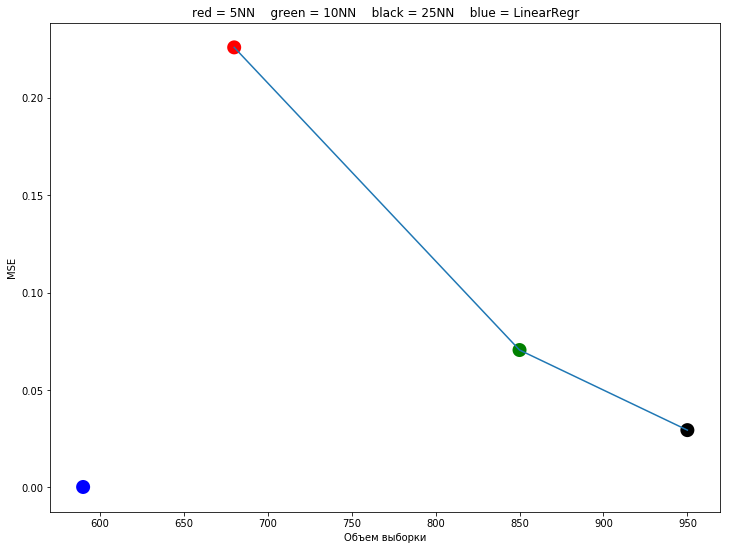

In [341]:
plt.figure(figsize=(12,9))
plt.plot(data_volume, MSE_vals)
data_volume.append(lr_volume)
MSE_vals.append(lr_mse)
plt.scatter(data_volume, MSE_vals, c=['red', 'green', 'black', 'blue'], linewidths=8)
plt.legend(loc=1)
plt.xlabel("Объем выборки")
plt.ylabel("MSE")
plt.title("red = 5NN    green = 10NN    black = 25NN    blue = LinearRegr")
plt.show()

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        pp.PolynomialFeatures(degree=d_new)
        X_new = pp.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [342]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [343]:
from sklearn.preprocessing import PolynomialFeatures

In [344]:
err_1 = []
LRs_1 = []
for N in N_grid:
    LR = lm.LinearRegression()
    rnd_ind = np.random.choice(np.arange(X.shape[0]), N)
    LR.fit(X[rnd_ind], y[rnd_ind])
    LRs_1.append(LR)
    y_pred = LR.predict(X)
    err_1.append(mean_squared_error(y_gt, y_pred))

err_2 = []
LRs_2 = []
pp = PolynomialFeatures(degree=2)
X_new_2 = pp.fit_transform(X)
for N in N_grid:
    LR = lm.LinearRegression()
    rnd_ind = np.random.choice(np.arange(X_new_2.shape[0]), N)
    LR.fit(X_new_2[rnd_ind], y[rnd_ind])
#     LR.fit(X_new_2[:N], y[:N])
    LRs_2.append(LR)
    y_pred = LR.predict(X_new_2)
    err_2.append(mean_squared_error(y_gt, y_pred))

err_3 = []
LRs_3 = []
pp = PolynomialFeatures(degree=5)
X_new_3 = pp.fit_transform(X)
for N in N_grid:
    LR = lm.LinearRegression()
    rnd_ind = np.random.choice(np.arange(X_new_3.shape[0]), N)
    LR.fit(X_new_3[rnd_ind], y[rnd_ind])
#     LR.fit(X_new_3[:N], y[:N])
    LRs_3.append(LR)
    y_pred = LR.predict(X_new_3)
    err_3.append(mean_squared_error(y_gt, y_pred))

Код для построения всех графиков:

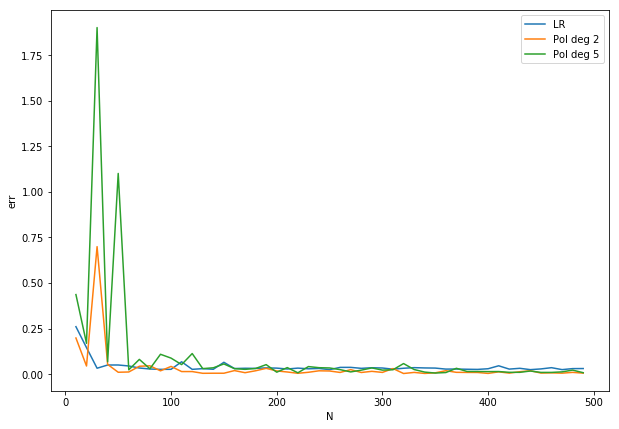

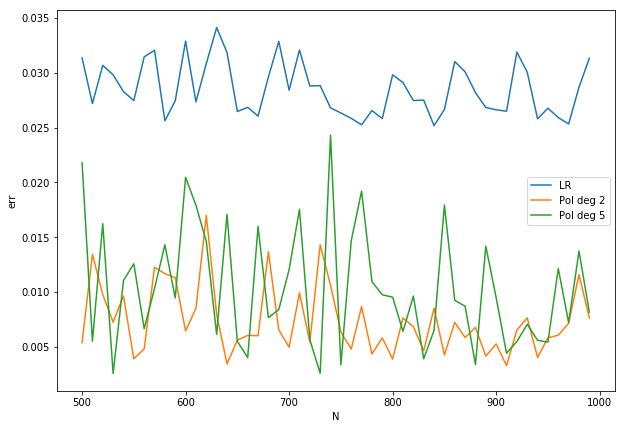

In [345]:
plt.figure(figsize=(10,7))
N_grid = np.array(N_grid)
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.figure(figsize=(10,7))
plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

In [346]:
print(np.argmin(err_1))
print(err_1[np.argmin(err_1)])
print(np.argmin(err_2))
print(err_2[np.argmin(err_2)])
print(np.argmin(err_3))
print(err_1[np.argmin(err_3)])

83
0.0251735824718
90
0.0032735312394
52
0.0298127673592


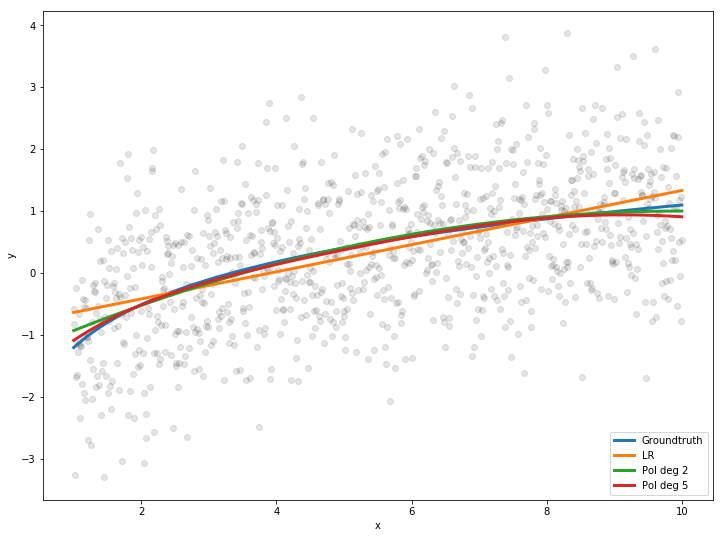

In [347]:
plt.figure(figsize=(12,9))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

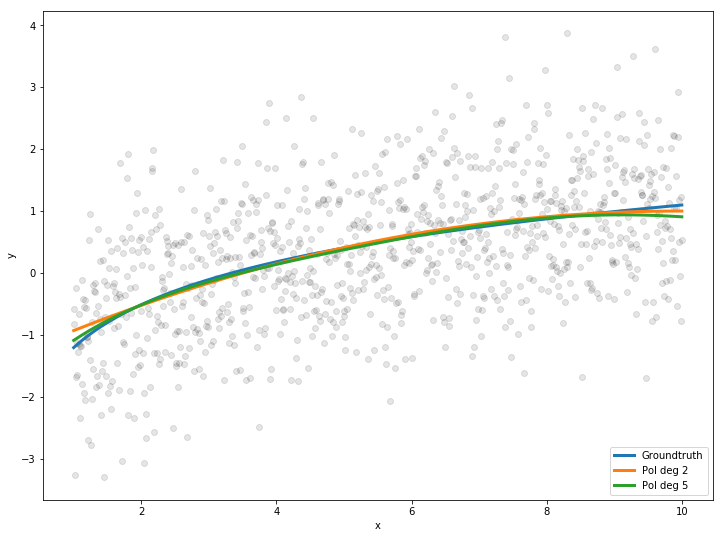

In [348]:
plt.figure(figsize=(12,9))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Лучше всего себя показала регрессия с полиномиальными признаками 2й степени:  
Ошибка достигла своего минимума уже при размере обучающей выборки = 590 (в отличие от 910 и 920 для двух других)  
При этом сама ошибка примерно в 5 раз меньше  
Это можно объяснить тем, что изначальная функция имеет логарифмическую зависимость, поэтому квадратичные признаки описывают ее лучше чем просто прямая  
А в случае со степенью признаков 5 происходит переобучение и поэтому, например, получается очень большая ошибка при маленьких обучающих выборках

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [349]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

для чуть большей правдивости обучил не на полной выборке, но предиктил для полной, так как графики в этом случае более показательны

In [350]:
from sklearn.model_selection import train_test_split

In [351]:
X_train, X_test, y_train, y_test, y_gt_train, y_gt_test = train_test_split(X, y, y_gt, test_size=0.2, random_state=42)

In [352]:
LR = lm.LinearRegression()
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X)

In [353]:
Ridge = lm.Ridge()
Ridge.fit(X_train, y_train)
y_pred_Ridge = Ridge.predict(X)

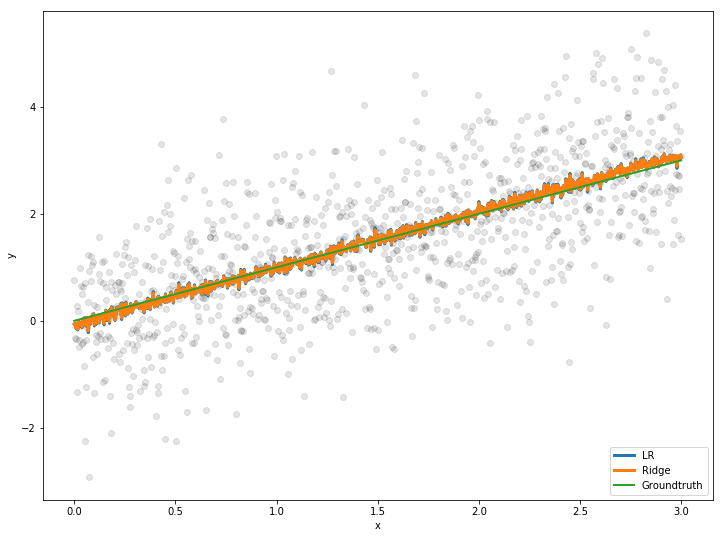

In [354]:
plt.figure(figsize=(12,9))
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

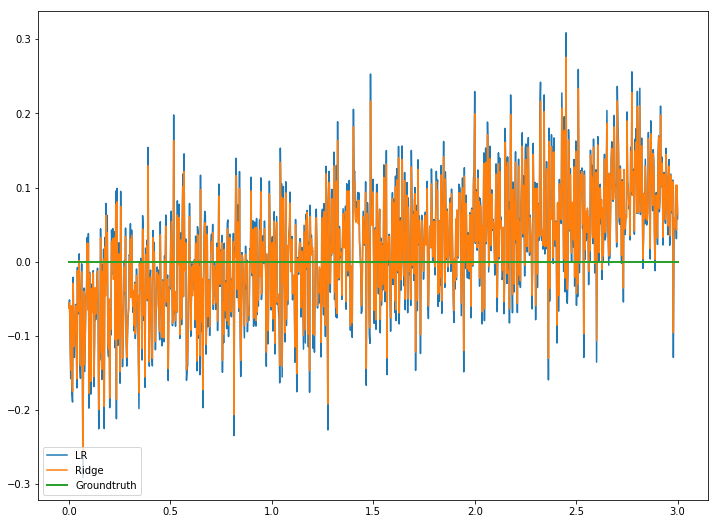

In [355]:
plt.figure(figsize=(12,9))
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [356]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

7.85114722549
6.45762085754


In [357]:
print(LR.coef_)
print(Ridge.coef_)

[[-0.348314    0.67060133  0.01974602]]
[[-0.14206185  0.56352323  0.02260012]]


Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Модель с Ridge регуляризацией показывает себя лучше. Из первого графика можно наблюдать эффект переобучения первой модели(LR), это подтверждается и большими весами: у нее больше веса => маленькое изменение признака сильнее влияет на результат, поэтому разница с groundtruth по сравнению с Ridge тоже увеличивается(второй график)

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [37]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [38]:
X_train, X_test, y_train, y_test, y_gt_train, y_gt_test = train_test_split(X, y, y_gt, test_size=0.3, random_state=42)

In [39]:
Ridge = lm.Ridge()
Ridge.fit(X_train, y_train)
y_pred_Ridge = Ridge.predict(X_test)

In [40]:
Lasso = lm.Lasso()
Lasso.fit(X_train, y_train)
y_pred_Lasso = Lasso.predict(X_test)

In [41]:
print(Ridge.coef_)
print(Lasso.coef_)

[[ 0.8678714   1.05994699  0.10603209 -0.08474944]]
[ 0.          0.          0.17008514  0.05145259]


In [42]:
print(mean_squared_error(y_gt_test, y_pred_Ridge))
print(mean_squared_error(y_gt_test, y_pred_Lasso))

0.00356725716841
1.07898200488


In [43]:
from sklearn.metrics import mean_absolute_error

In [44]:
print(mean_absolute_error(y_gt_test, y_pred_Ridge))
print(mean_absolute_error(y_gt_test, y_pred_Lasso))

0.0469661719501
0.853117264082


Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Ridge сохраняет все признаки но уменьшает их веса, а Lasso зануляет лишние признаки(в данном случае 2 из 4х, так как 2 линейно независимы). Но по MSE и MAE Ridge лучше, видимо зануление двух признаков приводит к слишком большой обобщающей способности + Lasso занулил второй признак, а Ridge дал ему большой вес, что привело к лучшим метрикам => важный признак

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [45]:
import pandas as pd

In [46]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [47]:
data = data.iloc[:,5:]

In [48]:
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [49]:
(data.apply(lambda x: x.count(), axis=1) < 123).mean()

0.84002006018054165

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

In [50]:
import seaborn as sns

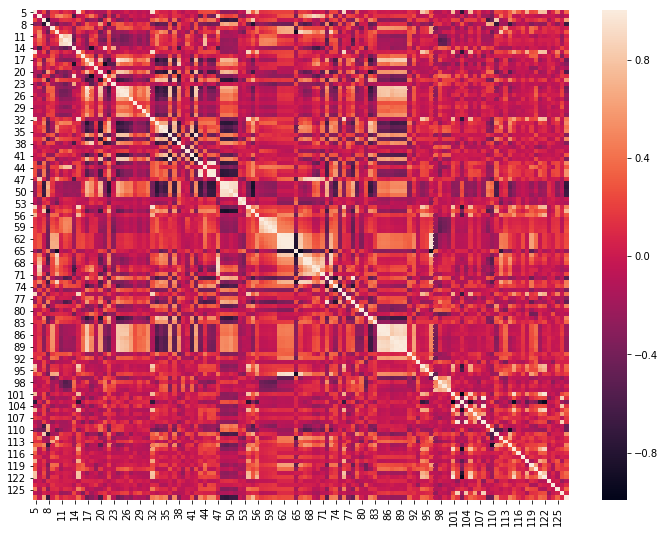

In [51]:
plt.figure(figsize=(12,9))
sns.heatmap(data.corr())

In [52]:
mask = np.abs(data.corr()) > 0.5
rng = [np.arange(5, 128)]*2
xx, yy = np.meshgrid(*rng)
x_corr = np.array(xx[mask])
y_corr = np.array(yy[mask])

# пары индексов всех признаков, которых абсолютная корреляция > 0.5
# чтобы знать какие признаки откинуть потом, например
corr_tuples = np.hstack([x_corr.reshape(-1, 1), y_corr.reshape(-1, 1)])
corr_tuples.shape[0]

1661

В итоге 1571 пар абсолютно коррелирующих признаков на уровне > 0.5 из 15625 пар (то есть порядка 10%)


#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

In [53]:
corr_matr = data.corr()

In [54]:
corr_127 = np.abs(corr_matr[127][:-1]) # выкинул корреляцию самого с собой — очевидно, что она = 1, а это нам не нужно
max_corr = corr_127.argmax()
min_corr = corr_127.argmin()

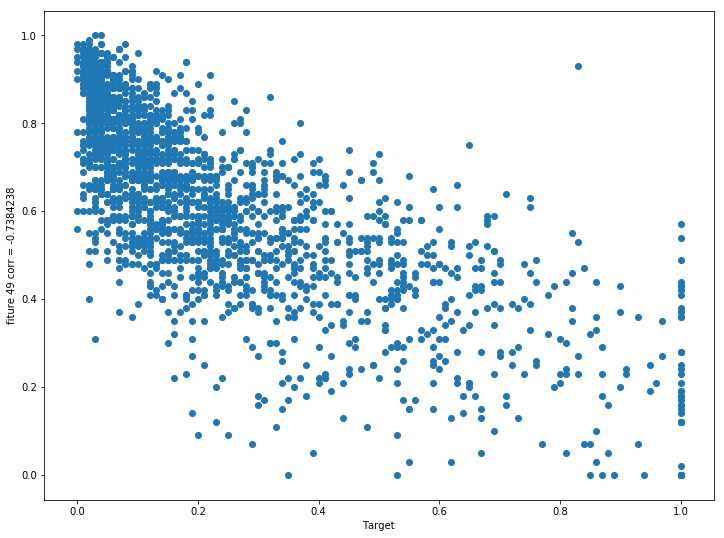

In [55]:
plt.figure(figsize=(12,9))
plt.scatter(data[127], data[max_corr])
plt.xlabel("Target")
plt.ylabel("fiture 49 corr = -0.7384238")
plt.show()

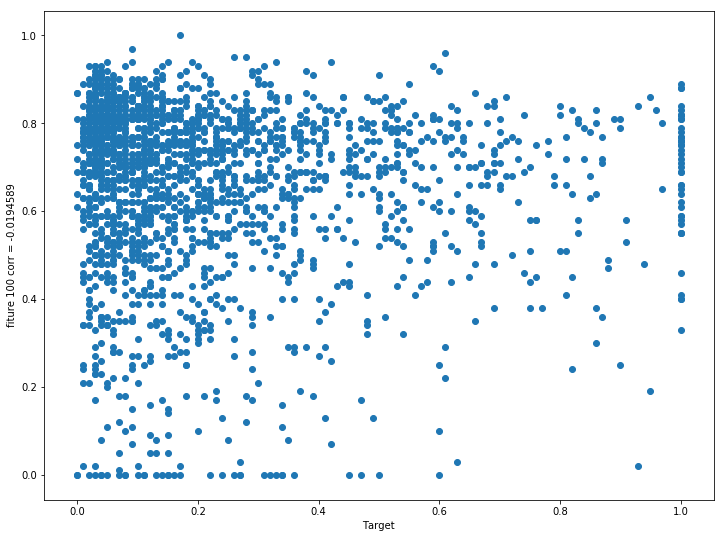

In [56]:
plt.figure(figsize=(12,9))
plt.scatter(data[127], data[min_corr])
plt.xlabel("Target")
plt.ylabel("fiture 100 corr = -0.0194589")
plt.show()

#### 3. Постройте гистограмму распределения предсказываемого значения.

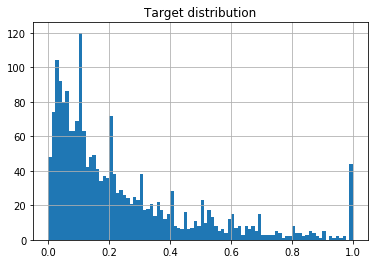

In [57]:
data[127].hist(bins=90)
plt.title('Target distribution')
plt.show()

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [58]:
data = data.fillna(data.mean())

In [59]:
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [60]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [61]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [62]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [63]:
LR = lm.LinearRegression()
LR.fit(X_train_new,y_train_new)
y_pred = LR.predict(X_test)
err = mean_squared_error(y_test, y_pred)
err

2.2424351857638962

#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [65]:
Rparam_grid = {'alpha': np.linspace(0, 70, 100)} 
gsR = GridSearchCV(lm.Ridge(), param_grid=Rparam_grid) 
Lparam_grid = {'alpha': np.linspace(0.0001,0.005, 100)} 
gsL = GridSearchCV(lm.Lasso(), param_grid=Lparam_grid)

In [66]:
gsR.fit(X_validate, y_validate)
gsL.fit(X_validate, y_validate)

/Users/dns/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001 ,  0.00015, ...,  0.00495,  0.005  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [67]:
print(gsR.best_params_)
print(gsL.best_params_)
print(gsR.best_score_)
print(gsL.best_score_)

{'alpha': 4.9494949494949498}
{'alpha': 0.00044646464646464645}
0.603796008065
0.605524525646


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [68]:
best_Ridge = gsR.best_estimator_
best_Lasso = gsL.best_estimator_
best_Ridge.fit(X_train_new, y_train_new)
best_Lasso.fit(X_train_new, y_train_new)

Lasso(alpha=0.00044646464646464645, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [69]:
print(mean_squared_error(y_test, best_Ridge.predict(X_test)))
print(mean_squared_error(y_test, best_Lasso.predict(X_test)))

0.0185222376884
0.0187304559906


In [70]:
print(best_Ridge.coef_)
print(best_Lasso.coef_)

[-0.02495977 -0.01194867  0.12988726 -0.08034922 -0.03516426  0.03973141
  0.02269735 -0.05895174 -0.01454598  0.02594172 -0.02858045  0.03907891
  0.01933834 -0.05395603  0.01509639 -0.10128149  0.01682716  0.05832096
 -0.05788567  0.01500197 -0.00029776 -0.0276862  -0.01874631 -0.01651269
  0.02175903  0.02789956  0.02920773  0.00393243 -0.04586791 -0.03180639
  0.03730332 -0.00681637 -0.02744112  0.0478196  -0.03959614 -0.01181656
  0.00502025 -0.01101579  0.07186238  0.03900225 -0.00310152  0.02482738
  0.0193791  -0.07019212 -0.10264264 -0.04304784 -0.02343115 -0.00452004
 -0.07393769 -0.01225318  0.16926299 -0.01594886  0.0254331  -0.02255057
 -0.04229847  0.04098649  0.01704519  0.01558922  0.01075884  0.03029804
  0.02905341 -0.07632677 -0.01134651 -0.02104729  0.04807997 -0.00928353
 -0.00306277 -0.02433202  0.0595987   0.0355989   0.02751805  0.09126518
 -0.0482398   0.00350578  0.06417821 -0.04614696 -0.0135114  -0.0072746
 -0.01165969 -0.02601116  0.00464086  0.00942595 -0.

In [71]:
zero_features = np.argwhere(best_Lasso.coef_ == 0)
zero_features.shape
nonzero_features = np.argwhere(best_Lasso.coef_ != 0)

Коэфициент в лассо в 30 раз меньше, чем в ridge и зануляет 107 признаков (значит они не релевантны)

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [72]:
X_train_selected = X_train_new[:, nonzero_features.reshape(15, )]
y_train_selected = y_train_new
X_train_crop_selected = X_train.iloc[:, nonzero_features.reshape(15, )]
X_test_selected = X_test.iloc[:, nonzero_features.reshape(15, )]
X_validate_selected = X_validate.iloc[:, nonzero_features.reshape(15, )]

ValueError: cannot reshape array of size 37 into shape (15,)

In [ ]:
best_Ridge.fit(X_train_selected, y_train_selected)
best_Lasso.fit(X_train_selected, y_train_selected)

In [ ]:
print(mean_squared_error(y_test, best_Ridge.predict(X_test_selected)))
print(mean_squared_error(y_test, best_Lasso.predict(X_test_selected)))

Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных?

Ошибка на Ridge увеличилась на 0.0010960827985  
А ошибка у Lasso уменьшилась на 2.801-e07  
то есть видно что ошибка слабо изменилась, значит в изначальных признаках наиболее важными являются только 15 штук, а значит можно хранить меньше данных и быстрее обучаться (+ меньше вероятность переобучения)

#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train_new, y_train_new)
y_pred = knn.predict(X_test)
print(mean_squared_error(y_test, y_pred))

#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [ ]:
param_grid = {'n_neighbors': np.arange(2, 15 ), 'p': np.arange(1, 3)}
gs = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid)
gs.fit(X_validate, y_validate)

In [ ]:
gs.best_params_

In [ ]:
best_knn = gs.best_estimator_
best_knn.fit(X_train_new, y_train_new)
y_pred = best_knn.predict(X_test)
print(mean_squared_error(y_test, y_pred))

С помощью какого алгоритма удалось достичь лучшего качества?

MSE(Ridge_10) = 0.0214327455089  
MSE(Lasso_0.0016545) = 0.022593566297  
MSE(KNN9_1) = 0.0249058679161  

Лучший — Линейная регрессия с L2 регуляризацией(alpha = 10)

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

В датасете много фич, и достаточно много пропусков(нельзя, например просто выкинуть примеры с пропусками, приходится их заполнять)  
Также достаточно много коррелирующих признаков(порядка 10% всех возможных пар абсолютно коррелируют на уровне > 0.5)  
Распределение целевого признака похоже на хи-квадрат(проверять гипотезу я, конечно же, не буду)  
Для работы с датасетом применялись 3 метода машинного обучения — линейная регрессия с L1 или L2 регуляризацией, а также KNNRegressor  
С помощью Lasso удалось выявить, что только 15 признаков наиболее сильно влияют на предсказание целевого признака (полагаю это как раз связано с линейной зависимость и корреляцией изначальных признаков)  
В данном случае датасет перемешивался перед разбиением просто случайно, и от этого зависил итоговый результат, поэтому я бы попробовал Ridge и Lasso при разных разбиениях и посмотрел, кто в среднем лучше  
(хотя при текущем разбиении лучше именно Ridge)
И еще бы попробовал убрать лишние признаки с лассо, и применить уже к такому датасету Ridge, и если разница в ошибке не сильно изменится — это как минимум может съэкономить место на хранение данных

**UPD**: Как можно было заметить, при данном разбиении на *train test and validate* вообще лучшие показатели у обычной линейной регрессии. Но я запустил тот же код в другом ноутбуке (=> разбиение на *train test and validate* уже было другое) и уже там у обычной линейной регрессии был наихудший результат (а лучший у Ridge с небольшим отрывом от лассо)  
Мне так кажется random seed разбиения выборки тоже можно считать гиперпараметром :)

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [ ]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    
    #alpha_grid - массив перебираемых значений гиперпараметра
    #alpha - найденное оптимальное значение гиперпараметра 
    #err - массив среднеквадратичных отклонений для каждого из alpha_grid
    min_err = +np.inf
    err = []
    alpha = alpha_min
    for a in alpha_grid:
        regr = RegressionClass(alpha=a)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_validate)
        curr_err = mean_squared_error(y_validate, y_pred)
        err.append(curr_err)
        if curr_err < min_err:
            min_err = curr_err
            alpha = a
    return alpha, err, alpha_grid, min_err

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [ ]:
alpha, err, alpha_grid, min_err = optimizer(X_train, y_train, X_validate, y_validate, 
              0.001,70, lm.Ridge)

l2 = lm.Ridge(alpha=alpha)
l2.fit(X_train_new, y_train_new)
y_pred = l2.predict(X_test)
print(alpha)

# считаю, что предсказание = среднему по целевому признаку и считаю ошибку
# => если ошибка предсказания Ridge меньше этой ошибки, то он уже хорош
mv = [data.mean().iloc[-1]]*y_test.shape[0]
print(np.mean((mv - y_test)**2))
print(np.mean((y_pred - y_test)**2))


Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(alpha_grid, err)
plt.scatter(alpha_grid, err, alpha=0.7, linewidth=0.01)
plt.scatter(alpha, min_err, c='r', linewidth=8)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [ ]:
alpha, err, alpha_grid, min_err = optimizer(X_train, y_train, X_validate, y_validate, 
              0.0001,0.005, lm.Lasso)
print(alpha)
l1 = lm.Lasso(alpha=alpha)
l1.fit(X_train_new, y_train_new)

# считаю, что предсказание = среднему по целевому признаку и считаю ошибку
# => если ошибка предсказания Lasso меньше этой ошибки, то он уже хорош
mv = [data.mean().iloc[-1]]*y_test.shape[0] 
print(np.mean((mv - y_test)**2))
y_pred = l1.predict(X_test)
print(np.mean((y_pred - y_test)**2))


In [ ]:
plt.figure(figsize=(10,7))
plt.plot(alpha_grid, err)
plt.scatter(alpha_grid, err, alpha=0.7, linewidth=0.01)
plt.scatter(alpha, min_err, c='r', linewidth=8)
plt.show()

In [ ]:
# напоследок обучим обычную линейную регрессию
ll = lm.LinearRegression()
ll.fit(X_train_new, y_train_new)
y_pred = ll.predict(X_test)
print(np.mean((y_pred - y_test)**2))

Result:  
$\text{MSE(LR) = 0.0209014284}$  
$\text{MSE(L1) = 0.022056073}$  
$\text{MSE(L2) = 0.0218687913}$  
Ridge лучше чем Lasso, как и раньше  
Но простая линейная регрессия оказалась лучше обоих, полагаю такой эффект имеет место быть из-за того, что выборка на train, validate и test разбивалась случайно, и при другом разбиении скорее всего будет иначе

**UPD:**  
как уже писал выше, запускал в другом ноутбуке:  
$\text{MSE(LR) = 0.02026021135}$  
$\text{MSE(L1) = 0.0186911745595}$  
$\text{MSE(L2) = 0.01863631473841}$  
И обычная LR хуже остальных, а различия между L2 и L1 минимальны

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

In [ ]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.0001, 1, 20)
gamma_grid = np.linspace(0.001, 1, 20)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_crop_selected)
        X_validate_rbf = RBF.transform(X_validate_selected)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [ ]:
RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
X_train_rbf = RBF.fit_transform(X_train_selected)
X_test_rbf = RBF.transform(X_test_selected)
Ridge = lm.Ridge(alpha=alpha_best)
Ridge.fit(X_train_rbf, y_train_new)
y_pred = Ridge.predict(X_test_rbf)

print(np.mean((y_pred - y_test)**2))

In [ ]:
# просто ridge с alpha из бонуса 1 и 15ю фичами
Ridge = lm.Ridge(alpha=alpha)
Ridge.fit(X_train_selected, y_train_new)
y_pred = Ridge.predict(X_test_selected)

print(np.mean((y_pred - y_test)**2))

In [ ]:
gamma_best

$\text{MSE(RBF_15) = 0.021562288128373575}$  
$\text{MSE(L2_123) = 0.0218687913}$  
$\text{MSE(L2_15) = 0.022395462629665415}$ 

То есть RBF фичи в данном случае не дают особого приросто, однако все равно лучше чем просто Ridge с 123 фичами, и значительно лучше чем просто Ridge с 15 фичами  

**UPD:**  
как уже писал выше, запускал в другом ноутбуке:  
$\text{MSE(RBF_15) = 0.01797665824883}$  
$\text{MSE(L2_123) = 0.01863631473841}$  
$\text{MSE(L2_15) = 0.0187587732980}$ 
Цифры другие, но ошибка уменьшилась примерно как и в оригинальной версии (отличие в том, что здесь это все лучше чем просто линейная регрессия(0.02026021))